In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
X_2011 = pd.read_csv('./data/supply_2011.csv')
X_2016 = pd.read_csv('./data/supply_2016.csv')

In [5]:
del X_2011['Unnamed: 0']
del X_2016['Unnamed: 0']

X_2011 = np.array(X_2011) + 1e-2
X_2016 = np.array(X_2016) + 1e-2

In [6]:
X_2011_vec = X_2011.ravel()
X_2016_vec = X_2016.ravel()

In [7]:
u = X_2016.sum(axis = 1)

In [8]:
v = X_2016.sum(axis = 0)

In [9]:
c = np.block([u,v])

In [10]:
def create_G(param):

    G = np.zeros((param*2,param**2))

    for i in range(59):
        for j in range(len(G[i])):
            if j >=i*59 and j <= (i+1)*59 - 1:
                G[i][j] = 1
    for i in range(59,118):
        for j in range(len(G[i])):
            if j%59 == i - 59:
                G[i][j] = 1
                
    G[-1][-60] = 2   # хитрость, немного смещающая проекцию, однако гарантирующая невырожденность системы в случае не слишком разреженного гессиана
    return G

G = create_G(X_2011.shape[0])

In [11]:
def construct_hessian(vec):
    return np.linalg.inv(np.diag(vec))


hess = construct_hessian(X_2011_vec)

In [12]:
def construct_gradient(point,vec):
    return np.dot(np.linalg.inv(np.diag(vec)),point) - np.ones(len(vec)) 

    
grad = construct_gradient(X_2016_vec,X_2011_vec)

In [13]:
grad.shape

(3481,)

In [14]:
grad

array([ 0.58020171, -0.49188308, -0.67409987, ...,  0.        ,
        0.        ,  0.49533628])

In [15]:
def quality_function(x,y):
    return np.sum((x - y)**2/y)

def transpose(A):
    return np.array(pd.DataFrame(A).T)

def construct_system_matrix(hess,G):
    return np.block([[hess,transpose(G)],[G,np.zeros((G.shape[0],G.shape[0]))]])

def inverse_system_matrix(matrix):
    return np.linalg.inv(matrix)

def construct_right_part(grad,c):
    return np.block([-grad,c])

def induce_deltas(inversed_system_matrix,right_part):
    vec = np.dot(inversed_system_matrix, right_part)
    return vec[:59**2]

def brute_optimize_alpha(alpha_search_vector,delta_vector,x_old,function):
    memory = []
    for alpha in tqdm(alpha_search_vector):
        memory.append(function(x_old + alpha*delta_vector,X_2011_vec))
    best = np.argmin(memory)
    best_alpha = alpha_search_vector[best]
    return best_alpha

def return_new_point(x_old, best_alpha, delta):
    return x_old + best_alpha*transpose(delta)

In [16]:
system_matrix = construct_system_matrix(hess,G)

In [17]:
inversed_system_matrix = inverse_system_matrix(system_matrix)

In [18]:
right_part = construct_right_part(grad,c).reshape(-1,1)

In [19]:
right_part

array([[-5.80201706e-01],
       [ 4.91883075e-01],
       [ 6.74099869e-01],
       ...,
       [ 1.53540159e+06],
       [ 3.35547590e+05],
       [ 5.06279590e+05]])

In [20]:
delta = induce_deltas(inversed_system_matrix,right_part)

In [21]:
delta

array([[5.15304939e+06],
       [4.08086951e+03],
       [8.17407424e+02],
       ...,
       [4.01829321e-03],
       [2.04488044e-03],
       [5.06277611e+05]])

In [22]:
alpha = np.linspace(0,0.05,31)

best_alpha = brute_optimize_alpha(alpha,delta,X_2011_vec,quality_function)

100%|██████████| 31/31 [00:02<00:00, 10.89it/s]


In [23]:
x_new = return_new_point(X_2011_vec, 20000, delta)

In [24]:
np.linalg.norm(X_2016-X_2011)

9744415.700009314

# Iterations

In [25]:
def create_G(param):

    G = np.zeros((param*2,param**2))

    for i in range(59):
        for j in range(len(G[i])):
            if j >=i*59 and j <= (i+1)*59 - 1:
                G[i][j] = 1
    for i in range(59,118):
        for j in range(len(G[i])):
            if j%59 == i - 59:
                G[i][j] = 1
    G[-1][-60] = 2
    return G

G = create_G(X_2011.shape[0])

In [27]:
### Cоберем это все в итерации
from scripts import metrics
from scripts import vectorization as v
import copy
def NEWTON(X_2011_vec,X_2016_vec,G,n_iter):
    vec = []
    vec_norm = []
    u = X_2016.sum(axis = 1)
    v = X_2016.sum(axis = 0)
    X_curr = X_2011_vec
    memory = X_2011_vec
    
    #print('Исходная норма разности: ' + str(np.linalg.norm(X_2016_vec - X_curr)))
    for i in range(n_iter):
        hess = construct_hessian(X_curr)
        grad = construct_gradient(X_curr,X_2011_vec)
        #print('Норма градиента: ' + str(np.linalg.norm(grad)))
        system_matrix = construct_system_matrix(hess,G)
        inversed_system_matrix = inverse_system_matrix(system_matrix)
        right_part = construct_right_part(grad,c).reshape(-1,1)
        delta = induce_deltas(inversed_system_matrix,right_part)
        
        x_new = return_new_point(X_curr,0.2/(5*i + 1), delta).reshape(1,-1)
        X_curr = x_new[0]
        vec.append(X_curr)
        #plt.spy(X_2016-X_curr.reshape(59,59))
        #plt.show()
        print('Норма разности матриц: ' + str(np.linalg.norm((X_2016-X_curr.reshape(59,59)))))
        vec_norm.append(X_2016-X_curr.reshape(59,59))
    print(X_curr)
    return X_curr,vec

In [28]:
RES = NEWTON(X_2011_vec,X_2016_vec,G,20)

Норма разности матриц: 4260443.5193637395
Норма разности матриц: 3451548.1926623075
Норма разности матриц: 3049611.0099694035
Норма разности матриц: 2797665.87576286
Норма разности матриц: 2623223.3123942357
Норма разности матриц: 2495825.225412168
Норма разности матриц: 2399809.5324814995
Норма разности матриц: 2326056.309746735
Норма разности матриц: 2268786.7703931276
Норма разности матриц: 2224108.8478138214
Норма разности матриц: 2189278.226312422
Норма разности матриц: 2162290.0261530075
Норма разности матриц: 2141637.930703598
Норма разности матриц: 2126164.390211885
Норма разности матриц: 2114963.313029016
Норма разности матриц: 2107314.525762371
Норма разности матриц: 2102638.2423895462
Норма разности матриц: 2100462.6093776007
Норма разности матриц: 2100399.9924897756
Норма разности матриц: 2102129.385798325
[4.97906294e+06 1.94943541e+03 4.66295995e+02 ... 1.23710261e-02
 1.20682480e-02 5.06044125e+05]


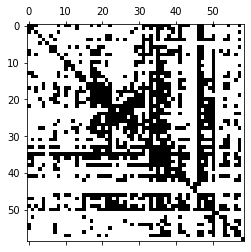

In [29]:
plt.spy(X_2016 - RES[1][-1].reshape(59,59),100)

In [30]:
''' Проверка, что знаки не меняются, если True во всех 3481'''

np.sum([X_2011*RES[1][-1].reshape(59,59)>0])

3481

In [31]:
pd.DataFrame(RES[1][-1].reshape(59,59)).to_csv('Newton_projection.csv')